In [1]:
import os
import re
import math
import json
import random
from tqdm.notebook import tqdm
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [2]:
QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [3]:
load_dotenv(override=True)

True

In [4]:
hf_token = os.getenv("HF_TOKEN")
login(hf_token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
from items import Item

In [6]:
with open("train.pkl","rb") as file:
    train = pickle.load(file)

In [7]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection("products")

In [8]:
result = collection.get(include=['embeddings','documents','metadatas'])
vectors = result['embeddings']
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

In [9]:
rf_model = RandomForestRegressor(n_estimators=5,random_state=42,n_jobs=2)
rf_model.fit(vectors,prices)

,n_estimators,5
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
joblib.dump(rf_model, "rf_model.pkl")

['rf_model.pkl']

In [11]:
rf_model = joblib.load("rf_model.pkl")

In [12]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [13]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

In [14]:
with open('test.pkl','rb') as file:
    test = pickle.load(file)

In [15]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [16]:
description(test[1])

'Motorcraft YB3125 Fan Clutch\nMotorcraft YB3125 Fan Clutch Package Dimensions 25.146 cms (L) x 20.066 cms (W) x 15.494 cms (H) Package Quantity 1 Product Type Auto Part Country Of Origin China Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch, Weight 5 pounds, Dimensions 10 x 7.63 x 6.25 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Rank Automotive Automotive Replacement Engine Fan Clutches 583, Domestic Shipping can be shipped within U.S., International Shipping This item can be shipped to select countries outside of the U.S. Learn More, Available October 10, 2007'

In [17]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $275.84 Truth: $374.41 Error: $98.57 SLE: 0.09 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $205.70 Truth: $225.11 Error: $19.41 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $184.64 Truth: $61.68 Error: $122.96 SLE: 1.18 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $485.64 Truth: $599.99 Error: $114.35 SLE: 0.04 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $172.88 Truth: $16.99 Error: $155.89 SLE: 5.15 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $149.12 Truth: $31.99 Error: $117.13 SLE: 2.30 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $281.76 Truth: $101.79 Error: $179.97 SLE: 1.02 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $312.11 Truth: $289.00 Error: $23.11 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $236.05 Truth: $635.86 Error: $399.81 SLE: 0.98 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $288.07 Truth: $65.99 Error: $222.08 S

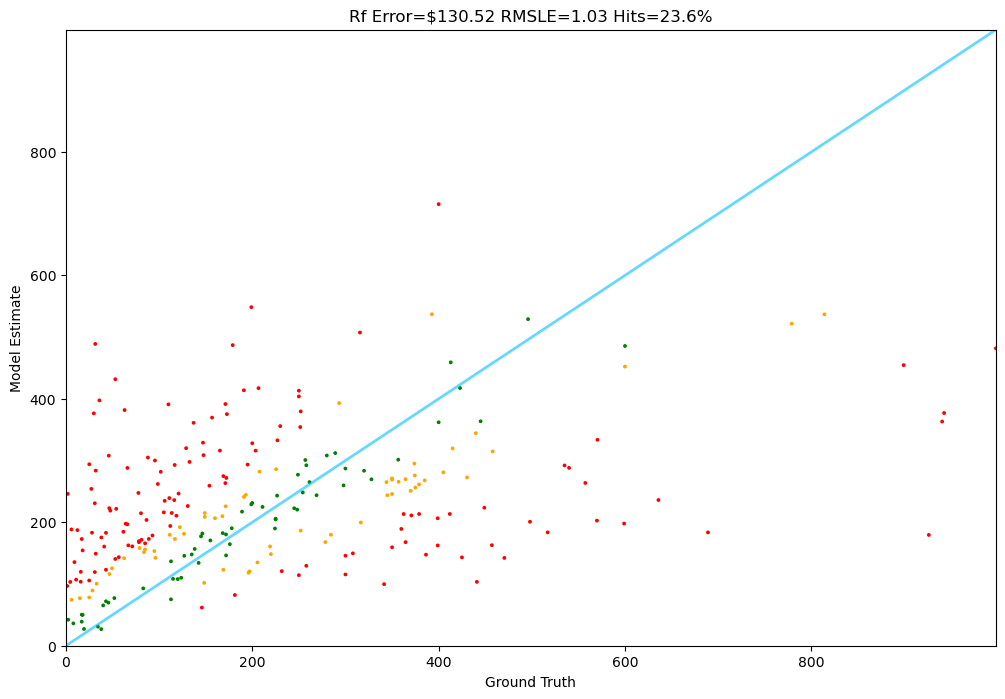

In [18]:
Tester.test(rf, test)

In [19]:
product = "Philips Speakers 2.0"

In [20]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

299.0
99.99
306.466


In [21]:
specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

  0%|          | 0/250 [00:00<?, ?it/s]

In [22]:
mins = [min(s,f,r) for s, f ,r in zip(specialists,frontiers, random_forests)]
maxs = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

In [23]:
X = pd.DataFrame({
    "Specialist": specialists,
    "Frontier": frontiers,
    "RandomForest": random_forests,
    "Min": mins,
    "Max": maxs
})
y = pd.Series(prices)

In [24]:
lr = LinearRegression()
lr.fit(X,y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [25]:
feature_columns = X.columns.tolist()

In [26]:
for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.49
Frontier: 0.44
RandomForest: 0.04
Min: 0.14
Max: -0.08
Intercept=25.17


In [27]:
joblib.dump(lr,"ensemble_model.pkl")

['ensemble_model.pkl']

In [32]:
from agents.ensemble_agent import EnsembleAgent

In [33]:
ensemble = EnsembleAgent(collection)

In [34]:
ensemble.price(product)

248.858535280251

In [35]:
def ensemble_pricer(item):
    return ensemble.price(description(item))

1: Guess: $334.87 Truth: $374.41 Error: $39.54 SLE: 0.01 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $132.60 Truth: $225.11 Error: $92.51 SLE: 0.28 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $85.26 Truth: $61.68 Error: $23.58 SLE: 0.10 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $485.67 Truth: $599.99 Error: $114.32 SLE: 0.04 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $31.82 Truth: $16.99 Error: $14.83 SLE: 0.36 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $36.78 Truth: $31.99 Error: $4.79 SLE: 0.02 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $133.26 Truth: $101.79 Error: $31.47 SLE: 0.07 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $317.72 Truth: $289.00 Error: $28.72 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $580.54 Truth: $635.86 Error: $55.32 SLE: 0.01 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $96.99 Truth: $65.99 Error: $31.00 SLE: 0.14 It

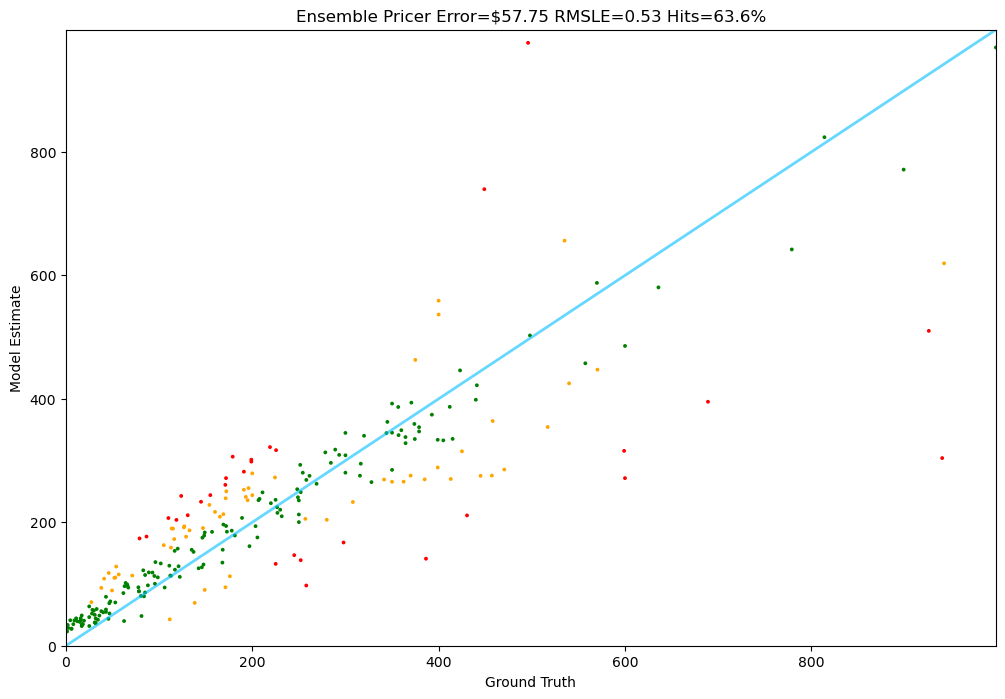

In [36]:
Tester.test(ensemble_pricer,test)